In [3]:
import pandas as pd

columns = [
    "Pregnancies",            # Số lần mang thai
    "Glucose",                # Nồng độ glucose huyết tương
    "BloodPressure",          # Huyết áp tâm trương
    "SkinThickness",          # Độ dày nếp gấp da (mm)
    "Insulin",                # Insulin huyết thanh (mu U/ml)
    "BMI",                    # Chỉ số khối cơ thể
    "DiabetesPedigreeFunction", # Hàm phả hệ tiểu đường (yếu tố di truyền)
    "Age",                    # Tuổi
    "Outcome"                 # Kết quả (0: Không mắc, 1: Mắc tiểu đường)
]
# Đọc dataset Pima Indians Diabetes
df = pd.read_csv("pima-indians-diabetes.csv", header=None, names=columns)
# Kiểm tra dòng trùng lặp
duplicates = df.duplicated()
print("Số dòng trùng lặp:", duplicates.sum())

# Xóa dòng trùng lặp
df_cleaned = df.drop_duplicates()
print("Kích thước sau khi xóa trùng lặp:", df_cleaned.shape)
print(df.head())

Số dòng trùng lặp: 0
Kích thước sau khi xóa trùng lặp: (768, 9)
   Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
0            6      148             72             35        0  33.6   
1            1       85             66             29        0  26.6   
2            8      183             64              0        0  23.3   
3            1       89             66             23       94  28.1   
4            0      137             40             35      168  43.1   

   DiabetesPedigreeFunction  Age  Outcome  
0                     0.627   50        1  
1                     0.351   31        0  
2                     0.672   32        1  
3                     0.167   21        0  
4                     2.288   33        1  


In [4]:
# NGƯỠNG RỘNG ĐỂ BẢO TOÀN DỮ LIỆU - CHỈ LỌC GIÁ TRỊ VÔ LÝ THỰC SỰ
physiological_ranges = {
    'Pregnancies': (0, 20),           # Số lần mang thai hợp lý
    'Glucose': (20, 300),             # Cho phép cả giá trị bệnh lý cao
    'BloodPressure': (40, 200),       # Bao gồm cả tăng huyết áp nặng
    'BMI': (10, 80),                  # Bao gồm cả béo phì bệnh lý
    'Age': (21, 100)                  # Tuổi hợp lý cho nghiên cứu
     # Với các chỉ số khác, có thể chỉ xử lý giá trị 0
}

In [5]:
def detect_physiological_errors(df, ranges):
    """Phát hiện dữ liệu ngoài ngưỡng sinh lý"""
    errors = {}
    
    for column, (min_val, max_val) in ranges.items():
        # Tìm các giá trị ngoài ngưỡng
        out_of_range = (df[column] < min_val) | (df[column] > max_val)
        error_count = out_of_range.sum()
        
        if error_count > 0:
            errors[column] = {
                'count': error_count,
                'min_actual': df[column].min(),
                'max_actual': df[column].max(),
                'problem_values': df[column][out_of_range].unique()
            }
    
    return errors

# Phát hiện lỗi
errors = detect_physiological_errors(df, physiological_ranges)
print("=== DỮ LIỆU LỖI PHÁT HIỆN ===")
for col, info in errors.items():
    print(f"{col}: {info['count']} giá trị lỗi")
    print(f"  - Range thực tế: {info['min_actual']} - {info['max_actual']}")
    print(f"  - Giá trị có vấn đề: {info['problem_values']}")

=== DỮ LIỆU LỖI PHÁT HIỆN ===
Glucose: 5 giá trị lỗi
  - Range thực tế: 0 - 199
  - Giá trị có vấn đề: [0]
BloodPressure: 39 giá trị lỗi
  - Range thực tế: 0 - 122
  - Giá trị có vấn đề: [ 0 30 24 38]
BMI: 11 giá trị lỗi
  - Range thực tế: 0.0 - 67.1
  - Giá trị có vấn đề: [0.]


In [6]:
# Chiến lược: XÓA các dòng có dữ liệu lỗi nghiêm trọng
def clean_physiological_errors(df, ranges):
    """Xóa dòng có dữ liệu ngoài ngưỡng sinh lý"""
    
    # Tạo mask để đánh dấu dòng lỗi
    error_mask = pd.Series(False, index=df.index)
    
    # Các chỉ số QUAN TRỌNG cần xử lý nghiêm ngặt
    critical_columns = ['Glucose', 'BloodPressure', 'BMI', 'Age']
    
    for column in critical_columns:
        min_val, max_val = ranges[column]
        # Đánh dấu dòng có giá trị ngoài ngưỡng
        error_mask |= (df[column] < min_val) | (df[column] > max_val)
    
    print(f"Số dòng có dữ liệu lỗi nghiêm trọng: {error_mask.sum()}")
    
    # Giữ lại các dòng KHÔNG có lỗi
    df_clean = df[~error_mask].copy()
    
    return df_clean

# Xử lý dữ liệu lỗi
df_clean = clean_physiological_errors(df, physiological_ranges)

Số dòng có dữ liệu lỗi nghiêm trọng: 48


In [7]:
# Sau khi xử lý lỗi nghiêm trọng, xử lý giá trị 0
def handle_zero_values(df):
    """Xử lý giá trị 0 bất thường trong các chỉ số sinh học"""
    
    # Các cột không được phép có giá trị 0
    zero_sensitive_columns = ['Glucose', 'BloodPressure', 'BMI', 'SkinThickness']
    
    for col in zero_sensitive_columns:
        zero_mask = df[col] == 0
        if zero_mask.any():
            print(f"Phát hiện {zero_mask.sum()} giá trị 0 trong {col}")
            
            # Thay thế bằng median của cột (không bao gồm giá trị 0)
            median_val = df[col][df[col] > 0].median()
            df.loc[zero_mask, col] = median_val
            print(f"  → Đã thay thế bằng median: {median_val:.2f}")
    
    return df

# Xử lý giá trị 0
df_final = handle_zero_values(df_clean)

Phát hiện 192 giá trị 0 trong SkinThickness
  → Đã thay thế bằng median: 29.00


In [8]:
print("=== KẾT QUẢ SAU XỬ LÝ ===")
print(f"Dữ liệu gốc: {len(df)} dòng")
print(f"Sau xử lý: {len(df_final)} dòng")
print(f"Tỷ lệ giữ lại: {len(df_final)/len(df)*100:.1f}%")

# Kiểm tra lại ngưỡng sinh lý
final_errors = detect_physiological_errors(df_final, physiological_ranges)
if not final_errors:
    print("✅ Tất cả dữ liệu đều trong ngưỡng sinh lý hợp lý")
else:
    print("❌ Vẫn còn dữ liệu lỗi:")
    for col, info in final_errors.items():
        print(f"  - {col}: {info['count']} lỗi")

=== KẾT QUẢ SAU XỬ LÝ ===
Dữ liệu gốc: 768 dòng
Sau xử lý: 720 dòng
Tỷ lệ giữ lại: 93.8%
✅ Tất cả dữ liệu đều trong ngưỡng sinh lý hợp lý


In [15]:
print(df_final.to_string()) 

     Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  DiabetesPedigreeFunction  Age  Outcome
0              6      148             72             35        0  33.6                     0.627   50        1
1              1       85             66             29        0  26.6                     0.351   31        0
2              8      183             64             29        0  23.3                     0.672   32        1
3              1       89             66             23       94  28.1                     0.167   21        0
4              0      137             40             35      168  43.1                     2.288   33        1
5              5      116             74             29        0  25.6                     0.201   30        0
6              3       78             50             32       88  31.0                     0.248   26        1
8              2      197             70             45      543  30.5                     0.158   53        1
1

## Ảnh ở mục 7.2

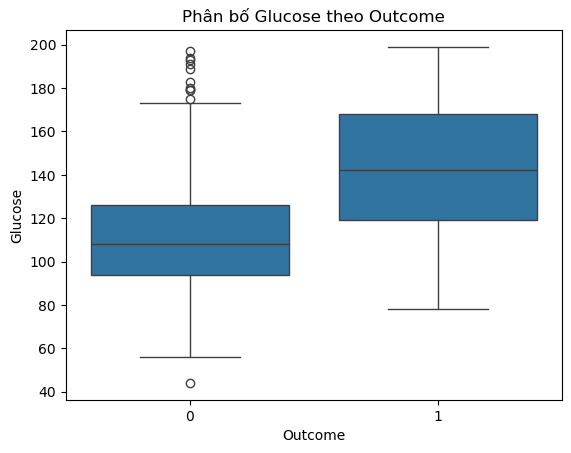

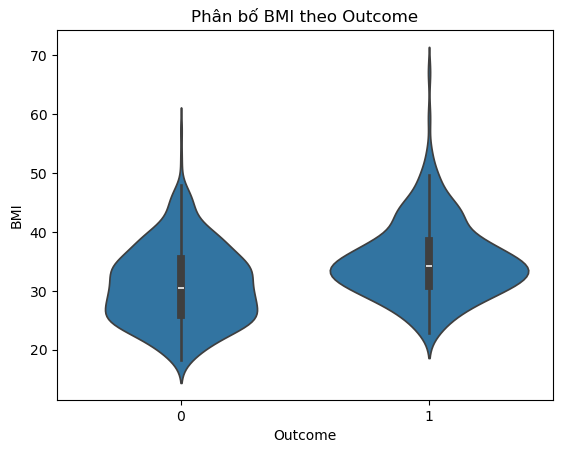

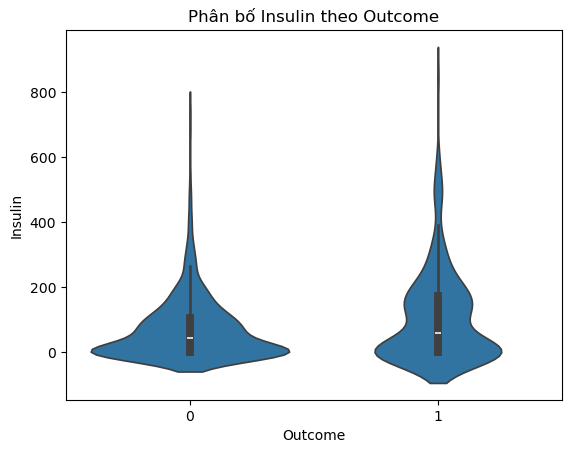

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt

# Boxplot Glucose
sns.boxplot(x='Outcome', y='Glucose', data=df_final)
plt.title("Phân bố Glucose theo Outcome")
plt.show()

# Violin plot BMI
sns.violinplot(x='Outcome', y='BMI', data=df_final)
plt.title("Phân bố BMI theo Outcome")
plt.show()

# Violin plot Insulin
sns.violinplot(x='Outcome', y='Insulin', data=df_final)
plt.title("Phân bố Insulin theo Outcome")
plt.show()


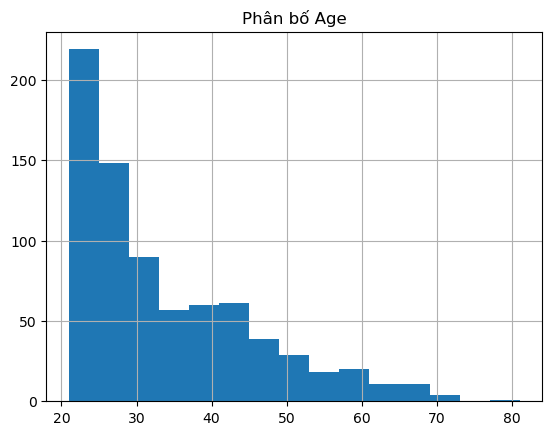

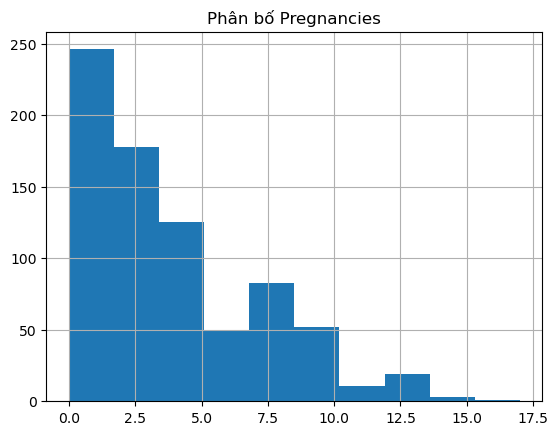

In [10]:
df['Age'].hist(bins=15)
plt.title("Phân bố Age")
plt.show()

df['Pregnancies'].hist(bins=10)
plt.title("Phân bố Pregnancies")
plt.show()


## Ảnh ở mục 7.3

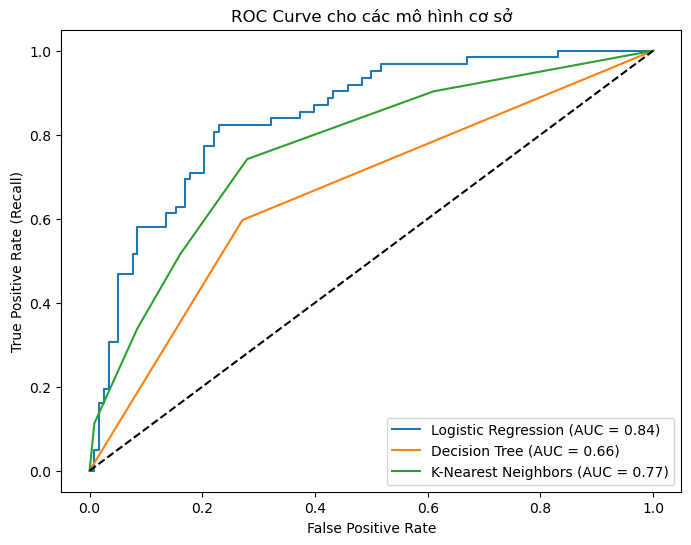

                 Model  Accuracy  Precision    Recall  F1-score       AUC
0  Logistic Regression  0.783333   0.734694  0.580645  0.648649  0.843904
1        Decision Tree  0.683333   0.536232  0.596774  0.564885  0.662794
2  K-Nearest Neighbors  0.727778   0.627451  0.516129  0.566372  0.767769


In [11]:
# Import thư viện
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScale
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve
import matplotlib.pyplot as plt


# 2. Chuẩn bị dữ liệu
X = df_final[['Pregnancies','Glucose','BloodPressure','SkinThickness','Insulin','BMI','DiabetesPedigreeFunction','Age']]
y = df_final['Outcome']

# 3. Chia dữ liệu train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)

# 4. Chuẩn hóa dữ liệu (đặc biệt cho KNN & Logistic)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 5. Khởi tạo mô hình
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'K-Nearest Neighbors': KNeighborsClassifier(n_neighbors=5)
}

# 6. Huấn luyện, dự đoán và đánh giá
results = []

plt.figure(figsize=(8,6))
for name, model in models.items():
    if name in ['Logistic Regression', 'K-Nearest Neighbors']:
        model.fit(X_train_scaled, y_train)
        y_pred = model.predict(X_test_scaled)
        y_pred_prob = model.predict_proba(X_test_scaled)[:,1]
    else:
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        y_pred_prob = model.predict_proba(X_test)[:,1]
    
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_pred_prob)
    
    results.append([name, acc, prec, rec, f1, auc])
    
    # Vẽ ROC
    fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
    plt.plot(fpr, tpr, label=f'{name} (AUC = {auc:.2f})')

# ROC plot tổng hợp
plt.plot([0,1],[0,1],'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate (Recall)")
plt.title("ROC Curve cho các mô hình cơ sở")
plt.legend()
plt.show()

# 7. Xuất bảng kết quả
results_df = pd.DataFrame(results, columns=['Model','Accuracy','Precision','Recall','F1-score','AUC'])
print(results_df)


## Ảnh ở mục 8.1.1

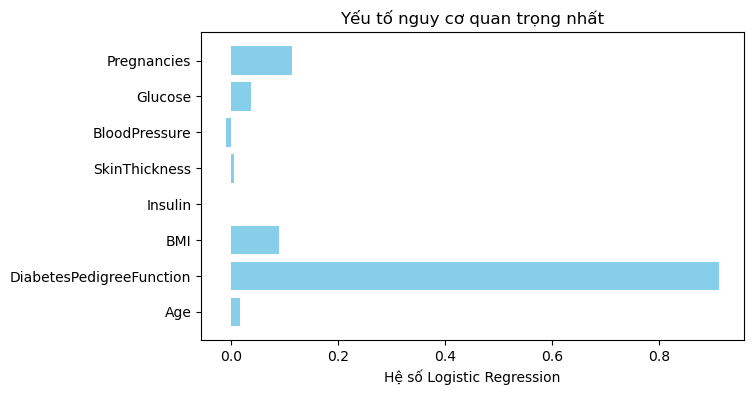

In [12]:
X = df_final[['Pregnancies','Glucose','BloodPressure','SkinThickness','Insulin','BMI','DiabetesPedigreeFunction','Age']]
y = df_final['Outcome']

model = LogisticRegression(max_iter=1000)
model.fit(X, y)

coefficients = model.coef_[0]
features = X.columns

# Vẽ biểu đồ
plt.figure(figsize=(7,4))
plt.barh(features, coefficients, color='skyblue')
plt.xlabel('Hệ số Logistic Regression')
plt.title('Yếu tố nguy cơ quan trọng nhất')
plt.gca().invert_yaxis()
plt.show()

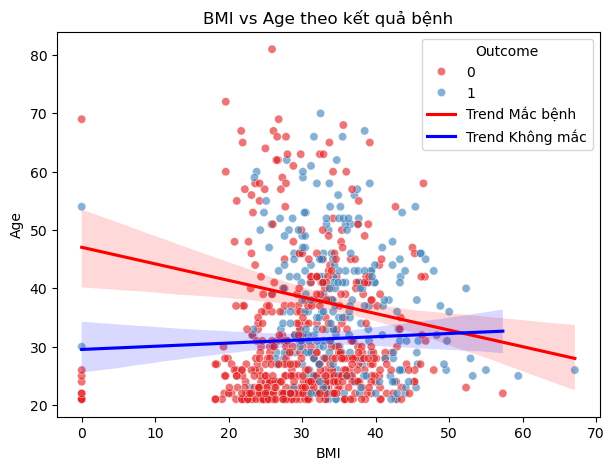

In [13]:
plt.figure(figsize=(7,5))
sns.scatterplot(data=df, x='BMI', y='Age', hue='Outcome', palette='Set1', alpha=0.6)
sns.regplot(data=df[df['Outcome']==1], x='BMI', y='Age', scatter=False, color='red', label='Trend Mắc bệnh')
sns.regplot(data=df[df['Outcome']==0], x='BMI', y='Age', scatter=False, color='blue', label='Trend Không mắc')
plt.title('BMI vs Age theo kết quả bệnh')
plt.xlabel('BMI')
plt.ylabel('Age')
plt.legend(title='Outcome')
plt.show()


## Ảnh này không dùng thấy đẹp nên để thôi

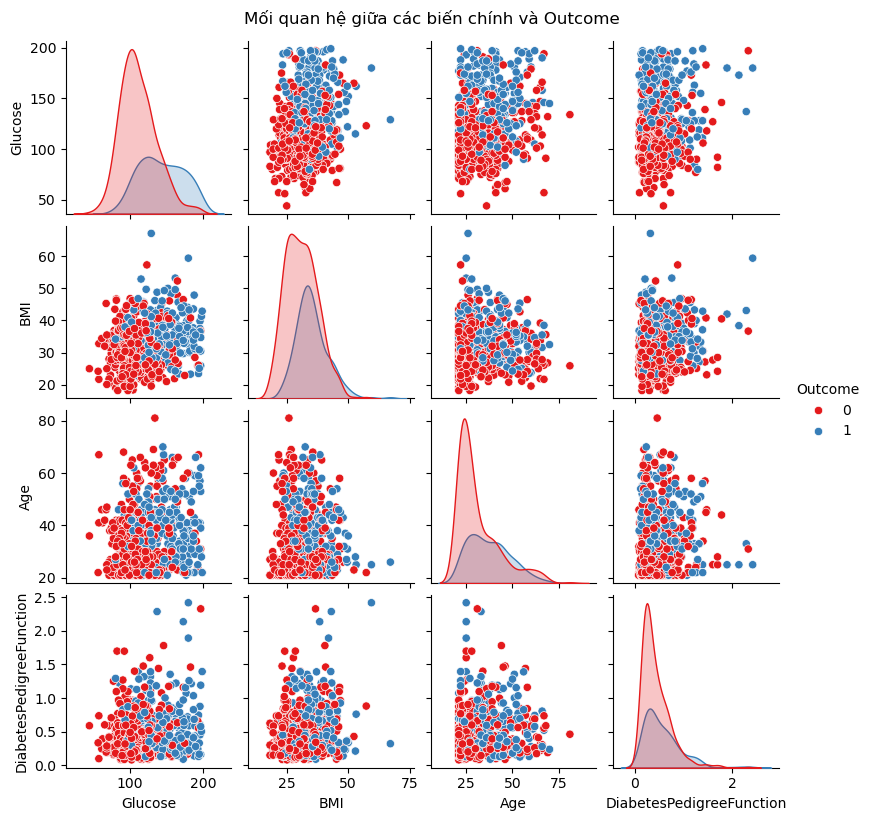

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.pairplot(
    df_final, 
    vars=['Glucose','BMI','Age','DiabetesPedigreeFunction'], 
    hue='Outcome', 
    palette='Set1', 
    diag_kind='kde',
    height=2  # giảm chiều cao mỗi subplot, mặc định là 2.5–3
)
plt.suptitle('Mối quan hệ giữa các biến chính và Outcome', y=1.02)
plt.show()
